In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import math
import os
import random

import matplotlib.pyplot as plt
plt.rc('font', family='Helvetica')

In [10]:
def get_vid_df(exp_name, time_offset=-1, interval=500, log_interval=500):
    
    assert(log_interval <= interval)
    div = int(interval / log_interval)
    
    with open(f'log_video_{exp_name}') as file:

        rows = []

        for line in file.readlines():
            line = line.strip().split('\t')
            vid_data = json.loads(line[7])
            
            for vid_log in vid_data:
                
                if next((row for row in rows if row[0] == vid_log['logCount']), None) == None:
                    
                    if vid_log['logCount'] == 0:
                        row = []
                        row.append(vid_log['logCount'])
                        row.append(vid_log['timeStamp'])
                        row.append(vid_log['timeElapsed'])
                        row.append(vid_log['totalFrames'])
                        row.append(vid_log['droppedFrames'])
                        row.append(vid_log['frameRate'])
                        row.append(vid_log['droppedFrames'])
                        row.append(instEncodedFrames := vid_log['totalFrames'])
                        row.append(encodedFPS := 0)
                        rows.append(row)
                    elif int(vid_log['logCount']) % div == 0:
                        row = []
                        row.append(vid_log['logCount'])
                        row.append(vid_log['timeStamp'])
                        row.append(vid_log['timeElapsed'])
                        row.append(vid_log['totalFrames'])
                        row.append(vid_log['droppedFrames'])
                        prevTimeElapsed = rows[-1][2]
                        prevTotalFrames = rows[-1][3]
                        prevDroppedFrames = rows[-1][4]
                        frameRate = ((vid_log['totalFrames'] - prevTotalFrames) - (vid_log['droppedFrames'] - prevDroppedFrames)) / (vid_log['timeElapsed'] - prevTimeElapsed)
                        row.append(frameRate)
                        try:
                            instFrameLoss = (vid_log['droppedFrames'] - prevDroppedFrames) / (vid_log['totalFrames'] - prevTotalFrames)
                        except ZeroDivisionError:
                            instFrameLoss = 0
                        instFrameLoss *= 100
                        row.append(instFrameLoss)
                        instEncodedFrames = vid_log['totalFrames'] - prevTotalFrames
                        encodedFPS = instEncodedFrames / (vid_log['timeElapsed'] - prevTimeElapsed)
                        row += [instEncodedFrames, encodedFPS]
                        rows.append(row)
                        
    vid_df = pd.DataFrame(rows, columns=['logCount', 'Time', 'timeElapsed', 'totalFrames', 'droppedFrames', 'Frame Rate', 'instFrameLoss', 'instEncodedFrames', 'encodedFPS'])
    vid_df['Time'] = (vid_df['Time'] - vid_df.iloc[0]['Time'])/1000 if time_offset == -1 else vid_df['Time']/1000 - time_offset
    vid_df['Time'] = vid_df['Time'] - 10
    vid_df['timeElapsed'] = vid_df['timeElapsed'] - vid_df.iloc[0]['timeElapsed']
    return vid_df

In [11]:
def get_fps(c1, c2, log_count):
    if log_count < c1:
        return 60
    elif log_count < c2:
        return 24
    else:
        return 48

def add_video_fps_to_df(vid_df, c1, c2):
    vid_df = vid_df.copy()

    vid_df['video_fps'] = vid_df['logCount']
    vid_df['video_fps'] = vid_df['video_fps'].apply(lambda log_count:get_fps(c1, c2, log_count))

    return vid_df

def get_framedrops(df, i, j):
    
    i, j = get_index_from_log_count(df, i), get_index_from_log_count(df, j)
    df = df.iloc[i:j].copy()

    total_frames = df.iloc[-1]['totalFrames'] - df.iloc[0]['totalFrames']
    dropped_frames = df.iloc[-1]['droppedFrames'] - df.iloc[0]['droppedFrames']
    percentage_dropped = (dropped_frames / total_frames) * 100 if total_frames > 0 else 0
    
    return percentage_dropped

def get_index_from_log_count(df, log_count):
    return int(df.loc[df['logCount'] >= log_count].index[0])

def get_log_count_from_time(df, time):
    return int(df.loc[df['Time'] >= time].iloc[0]["logCount"])

In [12]:
def plot_graph(vid_df, ax, c1, c2, title, show_video_fps=True, show_total_fps=False):

    vid_df = add_video_fps_to_df(vid_df, c1, c2)
    
    sns.lineplot(ax=ax, data=vid_df, x='Time', y='Frame Rate', linestyle='-', label='Rendered FPS') # -', marker='o')
    
    if show_video_fps:
        sns.lineplot(ax=ax, data=vid_df, x='Time', y='video_fps', linestyle='--', label='Selected FPS')

    if show_total_fps:
        sns.lineplot(ax=ax, data=vid_df, x='Time', y='encodedFPS', linestyle='-', label='Total FPS')
    
    ax.set_xlabel('Time ($s$)', fontsize=15)
    ax.set_ylabel("FPS ($s^{-1}$)", fontsize=15)
    ax.set_ylim(0, 70 if show_total_fps==False else 90)
    ax.set_xticks(range(0, 126, 5))
    ax.set_xlim(0, 110)
    ax.set_xticklabels(range(0, 126, 5))
    ax.set_title(title, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.grid()

    a = get_framedrops(vid_df, get_log_count_from_time(vid_df, 0), c1)
    b = get_framedrops(vid_df, c1, c2)
    c = get_framedrops(vid_df, c2, get_log_count_from_time(vid_df, 110))
    print(f'Frame drops at {title}:')
    print(f'60fps: {a:.2f}%')
    print(f'24fps: {b:.2f}%')
    print(f'48fps: {c:.2f}%')

In [13]:
def plot_subplot(vid_df, ax, c1, c2, title, show_video_fps=True, show_total_fps=False, has_xlabel=True):

    vid_df = add_video_fps_to_df(vid_df, c1, c2)
    
    sns.lineplot(ax=ax, data=vid_df, x='Time', y='Frame Rate', linestyle='-', label='Rendered FPS') # -', marker='o')
    
    if show_video_fps:
        sns.lineplot(ax=ax, data=vid_df, x='Time', y='video_fps', linestyle='--', label='Selected FPS') #, color='#DE3163')

    if show_total_fps:
        sns.lineplot(ax=ax, data=vid_df, x='Time', y='encodedFPS', linestyle='-', label='Total FPS')
    
    ax.set_ylabel("FPS ($s^{-1}$)", fontsize=15)
    if has_xlabel:
        ax.set_xlabel('Time ($s$)', fontsize=15)
    else:
        ax.set_xlabel("", fontsize=15)
    ax.set_yticks(range(0, 60+1, 10))
    ax.set_ylim(0, 70 if show_total_fps==False else 90)
    ax.set_xticks(range(0, 126, 5))
    ax.set_xlim(0, 110)
    ax.set_xticklabels(range(0, 126, 5))
    ax.set_title(title, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.grid(linestyle='-')

    # print('get_log_count_from_time(df, 0)', get_log_count_from_time(df, 0))
    a = get_framedrops(vid_df, get_log_count_from_time(vid_df, 0), c1)
    b = get_framedrops(vid_df, c1, c2)
    c = get_framedrops(vid_df, c2, get_log_count_from_time(vid_df, 110))
    print(f'Frame drops at {title}:')
    print(f'60fps: {a:.2f}%')
    print(f'24fps: {b:.2f}%')
    print(f'48fps: {c:.2f}%')

Frame drops at :
60fps: 53.53%
24fps: 11.66%
48fps: 18.13%


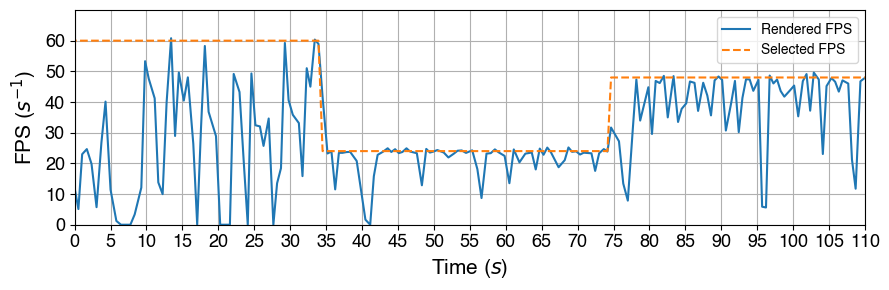

In [14]:
_, ax1 = plt.subplots(1, 1, figsize=(9, 3))

res = 480
exp_name = 'dubai_{}xfpsxp_{}'.format(res, f'm')
df = get_vid_df(exp_name, interval=500, log_interval=100)
plot_subplot(df, ax1, 342, 656, f'')

plt.tight_layout()
plt.savefig(f'moderate_480p_on_60_24_48_fps.jpg', dpi=300, pad_inches=0.00)

In [15]:
def plot_subplot(vid_df, ax, c1, c2, title, show_video_fps=True, show_total_fps=False, has_xlabel=True):

    vid_df = add_video_fps_to_df(vid_df, c1, c2)
    
    sns.lineplot(ax=ax, data=vid_df, x='Time', y='Frame Rate', linestyle='-', label='Rendered FPS') # -', marker='o')
    
    if show_video_fps:
        sns.lineplot(ax=ax, data=vid_df, x='Time', y='video_fps', linestyle='--', label='Selected FPS') #, color='#DE3163')

    if show_total_fps:
        sns.lineplot(ax=ax, data=vid_df, x='Time', y='encodedFPS', linestyle='-', label='Total FPS')
    
    ax.set_ylabel("FPS ($s^{-1}$)", fontsize=15)
    if has_xlabel:
        ax.set_xlabel('Time ($s$)', fontsize=15)
    else:
        ax.set_xlabel("", fontsize=15)
    ax.set_yticks(range(0, 60+1, 10))
    ax.set_ylim(0, 70 if show_total_fps==False else 90)
    ax.set_xticks(range(0, 126, 5))
    ax.set_xlim(0, 110)
    ax.set_xticklabels(range(0, 126, 5))
    ax.set_title(title, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.grid(linestyle='-')

    # print('get_log_count_from_time(df, 0)', get_log_count_from_time(df, 0))
    a = get_framedrops(vid_df, get_log_count_from_time(vid_df, 0), c1)
    b = get_framedrops(vid_df, c1, c2)
    c = get_framedrops(vid_df, c2, get_log_count_from_time(vid_df, 110))
    print(f'Frame drops at {title}:')
    print(f'60fps: {a:.2f}%')
    print(f'24fps: {b:.2f}%')
    print(f'48fps: {c:.2f}%')

Frame drops at 1080p:
60fps: 100.00%
24fps: 1.18%
48fps: 18.57%
Frame drops at 720p:
60fps: 12.58%
24fps: 1.05%
48fps: 8.89%
Frame drops at 480p:
60fps: 5.43%
24fps: 0.00%
48fps: 2.97%


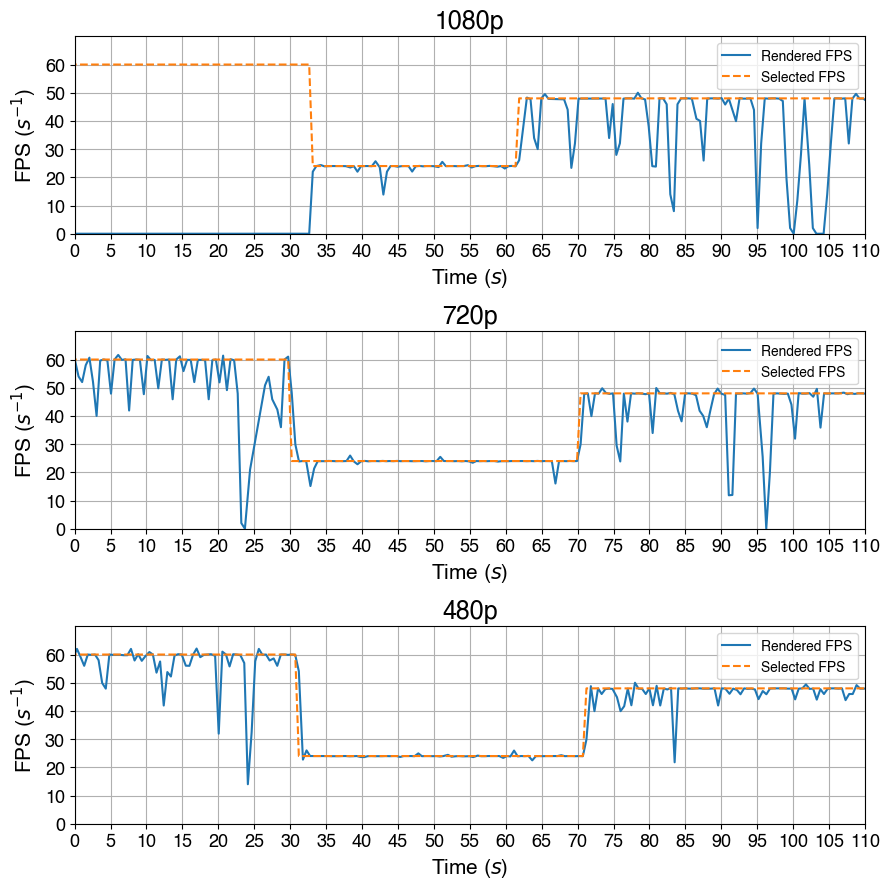

In [16]:
_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9))

res = 1080
exp_name = 'dubai_{}xfpsxp_{}'.format(res, f'n')
df = get_vid_df(exp_name, interval=500)
plot_subplot(df, ax1, 66, 122, f'{res}p', show_total_fps=False, has_xlabel=True)

res = 720
exp_name = 'dubai_{}xfpsxp_{}'.format(res, f'n')
df = get_vid_df(exp_name, interval=500)
plot_subplot(df, ax2, 72, 152, f'{res}p', has_xlabel=True)

res = 480
exp_name = 'dubai_{}xfpsxp_{}'.format(res, f'n')
df = get_vid_df(exp_name, interval=500)
plot_subplot(df, ax3, 81, 160, f'{res}p')

plt.tight_layout()
plt.savefig(f'xp_on_60_24_48_fps_yellow.jpg', dpi=300, pad_inches=0.0)